# EE4211 Project

## Question 1

Group name:

Group members: Liu Tianshu, Nie Hongtuo, Pan Jie, Zhang Chenxi

### Question 1.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')

First let's get the number of houses.

In [2]:
grouped = df.groupby(['dataid'])
len(grouped)

157

or

In [3]:
df.dataid.value_counts().size

157

We have gas flow meters installed in 157 houses.
Now we can find the anomaly samples in the data.

In [4]:
defect_id = []
for key,group in grouped:
    val = group.meter_value.values
    diff = val[1:] - val[:-1]
    defect_time = np.where(diff < 0)[0]
    if len(defect_time):
        defect_id.append(key)
        defect_time = group.localminute.values[defect_time + 1]
        print('The glitches of gas meter No.', key, 'happened in the moments below:')
        print(defect_time, '\n')

The glitches of gas meter No. 35 happened in the moments below:
['2015-10-20 09:00:12-05'] 

The glitches of gas meter No. 77 happened in the moments below:
['2015-10-20 20:20:55-05'] 

The glitches of gas meter No. 94 happened in the moments below:
['2015-11-01 01:11:10-06' '2015-11-01 01:17:53-06'
 '2015-11-01 01:23:12-06' '2016-01-16 10:23:43.197562-06'
 '2016-01-18 11:19:47.220413-06' '2016-01-18 11:26:52.211985-06'] 

The glitches of gas meter No. 483 happened in the moments below:
['2015-10-21 00:18:54-05'] 

The glitches of gas meter No. 484 happened in the moments below:
['2015-11-01 01:18:29-06' '2015-11-01 01:34:43-06'
 '2015-11-01 01:40:00-06' '2015-11-01 01:44:34-06'
 '2015-11-01 01:48:31-06' '2015-11-01 01:55:28-06'
 '2016-03-05 00:01:58.770374-06' '2016-03-05 01:43:22.133007-06'
 '2016-03-05 01:57:57.625975-06'] 

The glitches of gas meter No. 1042 happened in the moments below:
['2015-10-07 14:32:08-05'] 

The glitches of gas meter No. 1086 happened in the moments below:

In [5]:
print('The ID of the', len(defect_id), 'defective meters are:')
print(defect_id)

The ID of the 43 defective meters are:
[35, 77, 94, 483, 484, 1042, 1086, 1185, 1507, 1556, 1718, 1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193, 4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017, 7030, 7117, 7739, 7794, 7989, 8156, 8890, 9134, 9639, 9982]


43 gas meters have sent values that decreased at some point.
Let's look inside the data series given by a defective meter, for example, gas meter No. 9982.

/opt/anaconda3/envs/ee4211/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]),
 [Text(-200.0, 0, '2016-02-10 10:37:39.576638-06'),
  Text(0.0, 0, '2015-10-01 01:18:44-05'),
  Text(200.0, 0, '2015-10-31 14:35:17-05'),
  Text(400.0, 0, '2015-11-26 01:49:44-06'),
  Text(600.0, 0, '2015-12-13 07:19:48-06'),
  Text(800.0, 0, '2015-12-29 06:44:33-06'),
  Text(1000.0, 0, '2016-01-10 00:51:26.821519-06'),
  Text(1200.0, 0, '2016-01-30 02:47:33.45902-06'),
  Text(1400.0, 0, '2016-02-16 19:43:16.518007-06'),
  Text(1600.0, 0, ''),
  Text(1800.0, 0, '')])

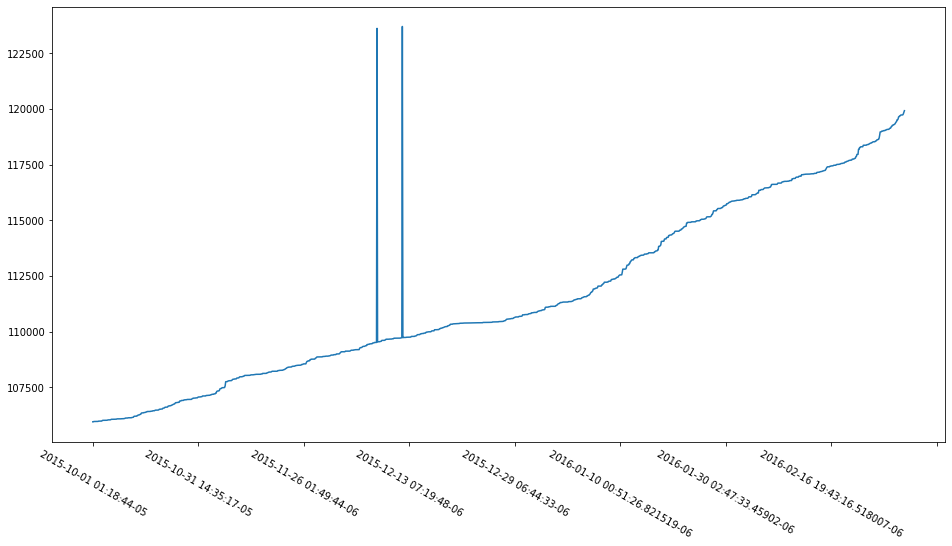

In [6]:
group = grouped.get_group(9982)
t = group.localminute.values
val = group.meter_value.values

s = pd.Series(val, index=t)
s.plot(figsize=(16, 8))
plt.xticks(rotation=-30)

### Question 1.2
Generate hourly readings from the raw data. Select one month from the 6-month
study interval and plot the hourly readings (time-series) for that month. Hint: You
will have to decide what to do if there are no readings for a certain hour.

In [7]:
# turn to timestamp
def local2utc(time):
    return pd.Timestamp(time)
df.localminute = df.apply(lambda r: local2utc(r.localminute), axis=1)

In [8]:
def select_data(df, month) -> pd.DataFrame:
    column_names = df.columns.values
    values = df.values
    values = filter(lambda x: x[0].month == month, values)
    values = pd.DataFrame(values)
    for i in range(len(column_names)):
        values = values.rename(columns={i:column_names[i]})
    return values

In [9]:
## select Oct data
month_data = select_data(df, 10)
print(month_data)

                     localminute  dataid  meter_value
0      2015-10-01 00:00:10-05:00     739        88858
1      2015-10-01 00:00:13-05:00    8890       197164
2      2015-10-01 00:00:20-05:00    6910       179118
3      2015-10-01 00:00:22-05:00    3635       151318
4      2015-10-01 00:00:22-05:00    1507       390354
...                          ...     ...          ...
266443 2015-10-31 23:59:30-05:00    3134       162910
266444 2015-10-31 23:59:34-05:00    9295       159480
266445 2015-10-31 23:59:49-05:00    2072       268650
266446 2015-10-31 23:59:54-05:00    3527       236018
266447 2015-10-31 23:59:55-05:00      94       117614

[266448 rows x 3 columns]


In [10]:
def hourly_data_by_group(df, month) -> set():
    month_dict = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    groups = df.groupby(['dataid'], sort=['localminute'])
    processed_group = {}
    for key in groups.groups.keys():
        new_group = []
        current_group = groups.get_group(key).values
        # init_first_point
        first_point = current_group[0]
        first_point[0] = first_point[0].replace(day = 1, hour = 0, minute = 0, second = 0)
        index_current_group = 0
        tmp = []
        # replace all time on the hour
        for row in current_group:
            row[0] = row[0].replace(minute = 0, second = 0)
            tmp.append(row)
        current_group = tmp
        # interpolate data 24 hour for 30 day
        for day in range(1, month_dict[month] + 1):
            for hour in range(0, 24):
                # make sure its the last data of the current time
                while (True):
                    if (index_current_group >= len(current_group)):
                        break
                    current_row = current_group[index_current_group]
                    time = current_row[0]
                    if (time.day == day and time.hour == hour):
                        index_current_group += 1
                    else:
                        break
                # assign data
                current_row = current_group[index_current_group - 1]
                time = current_row[0]
                date = pd.Timestamp(year = time.year, month = time.month, day = time.day, hour = time.hour, minute = 0, second = 0)
                current_row = [date, current_row[1], current_row[2]]
                if (time.day == day and time.hour == hour):
                    if (len(new_group) > 0 and new_group[-1][0].day == day and new_group[-1][0].hour == hour):
                        new_group[-1] = current_row
                    else:
                        new_group.append(current_row)
                else:
                    date = pd.Timestamp(year = time.year, month = time.month, day = day, hour = hour, minute = 0, second = 0)
                    row = [date,new_group[-1][1],new_group[-1][2]]
                    new_group.append(row)
        processed_group[key] = new_group
    return processed_group

In [11]:
hourly_data_groups = hourly_data_by_group(month_data, 10)

In [12]:
print(hourly_data_groups.keys(), '\n')
for i in hourly_data_groups[35]:
    print(i)

dict_keys([35, 44, 77, 94, 114, 187, 222, 252, 370, 483, 484, 661, 739, 744, 871, 1042, 1086, 1103, 1185, 1283, 1415, 1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461, 2470, 2575, 2638, 2645, 2818, 2945, 2965, 2980, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778, 3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4514, 4671, 4732, 4767, 4998, 5129, 5131, 5193, 5275, 5395, 5403, 5439, 5484, 5636, 5785, 5810, 5814, 5892, 5972, 6412, 6505, 6578, 6685, 6830, 6836, 6863, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7460, 7674, 7682, 7739, 7741, 7794, 7900, 7919, 7965, 7989, 8059, 8084, 8086, 8155, 8156, 8386, 8467, 8703, 8829, 8890, 8967, 9052, 9121, 9134, 9278, 9295, 9474, 9620, 9631, 9639, 9729, 9766, 9849, 9956, 9982]) 

[Timestamp('2015-10-01 00:00:00'), 35, 93470]
[Timestamp('2015-10-01 01:00:00'), 35, 93470]
[Timestamp('2015-10-01 02:00:00'), 35, 93470]
[Timestamp('201